In [1]:
import numpy as np
import pandas as pd
import random as rnd
from multiprocessing import Pool

from tensorflow import keras
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from IPython.display import Image 

rnd.seed(321)
np.random.seed(321)

In [2]:
SMALL_SIZE  = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size        = MEDIUM_SIZE)   # controls default text sizes
plt.rc('axes', titlesize   = SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize   = MEDIUM_SIZE)   # fontsize of the x and y labels
plt.rc('xtick', labelsize  = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize  = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize  = SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)   # fontsize of the figure title

In [3]:
# https://stackoverflow.com/questions/50393014/is-there-a-way-to-convert-an-image-from-grayscale-to-rgb-in-pure-keras
def grayscale_to_rgb(images, channel_axis=-1):
    images = K.expand_dims(images, axis=channel_axis)
    tiling = [1] * 4    # 4 dimensions: B, H, W, C
    tiling[channel_axis] *= 3
    images = K.tile(images, tiling)
    return images

In [4]:
def load_dataset(dataset, shape = (32,32)):
    
        if dataset == "cifar10":
            (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
            n_classes = 10
            
        elif dataset == 'mnist':
            (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
            n_classes = 10
            
            x_train = grayscale_to_rgb(x_train, channel_axis =-1)
            x_test  = grayscale_to_rgb(x_test, channel_axis =-1)

            x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
            x_test  = np.pad(x_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
                   
        
        x_train = x_train.astype('float32')
        x_test  = x_test.astype('float32')

        x_train = x_train.reshape((-1, 32, 32, 3))
        x_test  = x_test.reshape((-1, 32, 32, 3))

        evo_x_train, x_val, evo_y_train, y_val = train_test_split(x_train, y_train,
                                                                  test_size = 7000,
                                                                  stratify  = y_train)

        evo_x_val, evo_x_test, evo_y_val, evo_y_test = train_test_split(x_val, y_val,
                                                                        test_size = 3500,
                                                                        stratify  = y_val)

        
        evo_y_train = keras.utils.to_categorical(evo_y_train, n_classes)
        evo_y_val   = keras.utils.to_categorical(evo_y_val, n_classes)

        dataset     = {'evo_x_train': evo_x_train, 'evo_y_train': evo_y_train,
                       'evo_x_val': evo_x_val, 'evo_y_val': evo_y_val,
                       'evo_x_test': evo_x_test, 'evo_y_test': evo_y_test,
                       'x_test': x_test, 'y_test': y_test}
        
        return dataset

In [5]:
dataset_cifar10 = load_dataset("cifar10")

x_train_cifar10 = dataset_cifar10['evo_x_train']
y_train_cifar10 = dataset_cifar10['evo_y_train']

x_val_cifar10   = dataset_cifar10['evo_x_val']
y_val_cifar10   = dataset_cifar10['evo_y_val']

batch_size      = 337
epochs          = 500

step_epochs     = (dataset_cifar10['evo_x_train'].shape[0] // batch_size)

In [6]:
model = keras.models.load_model('disciplina/experiments/run_2/best.h5')

In [7]:
# in the validation test (just to confirm the result in the paper)
y_pred_test = model.predict(dataset_cifar10['evo_x_test'], batch_size = batch_size, verbose = 0)

y_pred_labels = np.argmax(y_pred_test, axis = 1)
accuracy_score(dataset_cifar10['evo_y_test'], y_pred_labels)

0.81

In [8]:
# acc in the test set
y_pred_test   = model.predict(dataset_cifar10['x_test'], batch_size = batch_size, verbose = 0)

y_pred_labels = np.argmax(y_pred_test, axis = 1)
accuracy_score(dataset_cifar10['y_test'], y_pred_labels)

0.8031

In [9]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 34)        442       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 34)        4658      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 34)        136       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        1855      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 53)        212       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 34)       

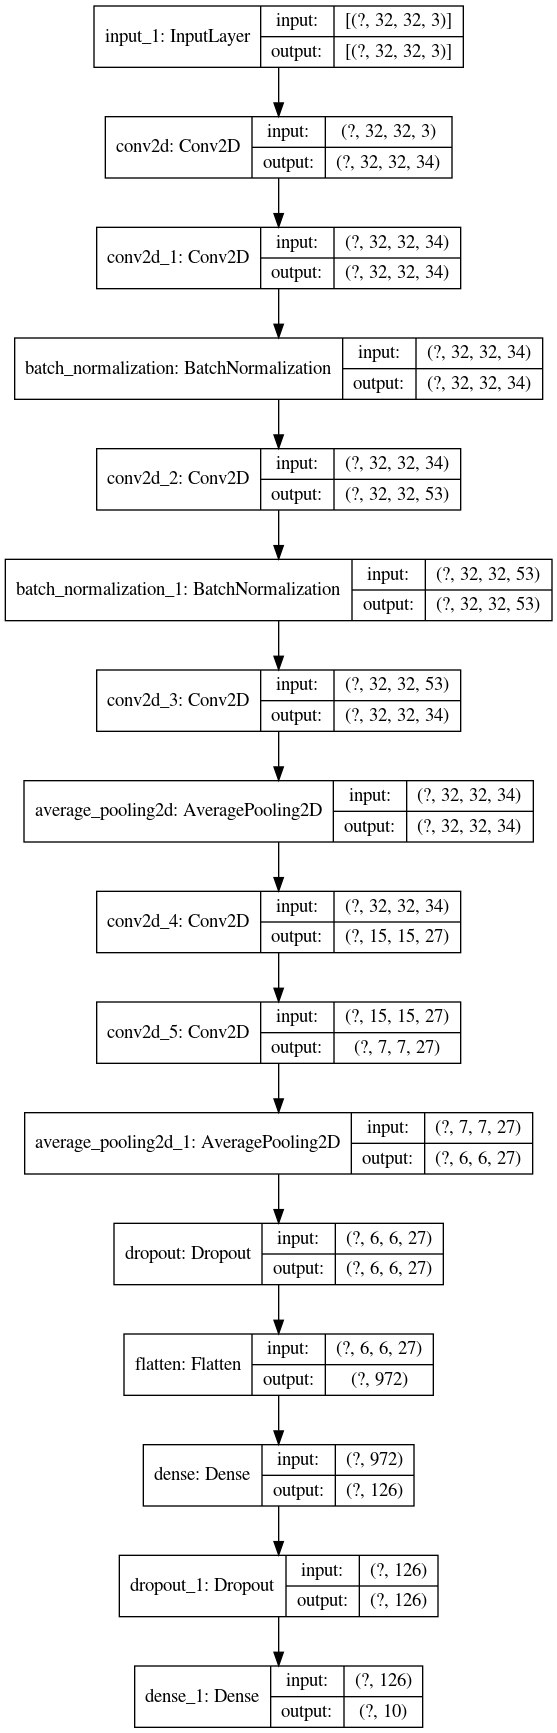

In [10]:
plot_model(model, show_shapes = True, show_layer_names = True)#, to_file='model.png')
# Image('model.png')

In [11]:
dataset_mnist = load_dataset("mnist")

x_train_mnist = dataset_mnist['evo_x_train']
y_train_mnist = dataset_mnist['evo_y_train']

x_val_mnist   = dataset_mnist['evo_x_val']
y_val_mnist   = dataset_mnist['evo_y_val']

batch_size    = 337
epochs        = 500

step_epochs   = (dataset_mnist['evo_x_train'].shape[0] // batch_size)

In [12]:
opt = keras.optimizers.SGD(lr       = 0.01272574740857138, 
                           momentum = 0.9190408624796864,
                           decay    = 0.0002731330475781741,
                           nesterov = False)

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 18)

model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [13]:
score = model.fit(x               = x_train_mnist, 
                  y               = y_train_mnist, 
                  batch_size      = batch_size,
                  epochs          = epochs,
                  steps_per_epoch = step_epochs,
                  validation_data = (x_val_mnist, y_val_mnist),
                  callbacks       = early_stop,
                  verbose         = True)

Epoch 1/500
157/157 [==============================] - 3s 20ms/step - loss: 0.6897 - accuracy: 0.8610 - val_loss: 0.2761 - val_accuracy: 0.9723
Epoch 2/500
157/157 [==============================] - 3s 18ms/step - loss: 0.2955 - accuracy: 0.9650 - val_loss: 0.2452 - val_accuracy: 0.9797
Epoch 3/500
157/157 [==============================] - 3s 18ms/step - loss: 0.2625 - accuracy: 0.9724 - val_loss: 0.2250 - val_accuracy: 0.9854
Epoch 4/500
157/157 [==============================] - 3s 18ms/step - loss: 0.2419 - accuracy: 0.9770 - val_loss: 0.2143 - val_accuracy: 0.9863
Epoch 5/500
157/157 [==============================] - 3s 18ms/step - loss: 0.2289 - accuracy: 0.9798 - val_loss: 0.2043 - val_accuracy: 0.9863
Epoch 6/500
157/157 [==============================] - 3s 18ms/step - loss: 0.2182 - accuracy: 0.9811 - val_loss: 0.1988 - val_accuracy: 0.9880
Epoch 7/500
157/157 [==============================] - 3s 18ms/step - loss: 0.2075 - accuracy: 0.9836 - val_loss: 0.1929 - val_accuracy:

Epoch 56/500
157/157 [==============================] - 3s 18ms/step - loss: 0.1013 - accuracy: 0.9924 - val_loss: 0.1051 - val_accuracy: 0.9897
Epoch 57/500
157/157 [==============================] - 3s 19ms/step - loss: 0.1015 - accuracy: 0.9924 - val_loss: 0.1014 - val_accuracy: 0.9906
Epoch 58/500
157/157 [==============================] - 3s 19ms/step - loss: 0.1001 - accuracy: 0.9928 - val_loss: 0.1005 - val_accuracy: 0.9914
Epoch 59/500
157/157 [==============================] - 3s 19ms/step - loss: 0.1002 - accuracy: 0.9929 - val_loss: 0.1024 - val_accuracy: 0.9926
Epoch 60/500
157/157 [==============================] - 3s 19ms/step - loss: 0.1006 - accuracy: 0.9917 - val_loss: 0.0993 - val_accuracy: 0.9911
Epoch 61/500
157/157 [==============================] - 3s 19ms/step - loss: 0.0972 - accuracy: 0.9932 - val_loss: 0.0988 - val_accuracy: 0.9909
Epoch 62/500
157/157 [==============================] - 3s 19ms/step - loss: 0.0989 - accuracy: 0.9925 - val_loss: 0.0984 - val_ac

157/157 [==============================] - 3s 20ms/step - loss: 0.0814 - accuracy: 0.9935 - val_loss: 0.0823 - val_accuracy: 0.9923
Epoch 113/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0807 - accuracy: 0.9938 - val_loss: 0.0818 - val_accuracy: 0.9917
Epoch 114/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0806 - accuracy: 0.9937 - val_loss: 0.0847 - val_accuracy: 0.9909
Epoch 115/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0795 - accuracy: 0.9936 - val_loss: 0.0824 - val_accuracy: 0.9917
Epoch 116/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0806 - accuracy: 0.9937 - val_loss: 0.0828 - val_accuracy: 0.9917
Epoch 117/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0798 - accuracy: 0.9934 - val_loss: 0.0810 - val_accuracy: 0.9917
Epoch 118/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0795 - accuracy: 0.9936 - val_loss: 0.0805 - val_accuracy:

157/157 [==============================] - 3s 20ms/step - loss: 0.0726 - accuracy: 0.9941 - val_loss: 0.0750 - val_accuracy: 0.9931
Epoch 169/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0745 - accuracy: 0.9934 - val_loss: 0.0737 - val_accuracy: 0.9926
Epoch 170/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0730 - accuracy: 0.9938 - val_loss: 0.0755 - val_accuracy: 0.9914
Epoch 171/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0729 - accuracy: 0.9940 - val_loss: 0.0752 - val_accuracy: 0.9920
Epoch 172/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0731 - accuracy: 0.9936 - val_loss: 0.0737 - val_accuracy: 0.9937
Epoch 173/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0726 - accuracy: 0.9939 - val_loss: 0.0752 - val_accuracy: 0.9917
Epoch 174/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0717 - accuracy: 0.9942 - val_loss: 0.0741 - val_accuracy:

157/157 [==============================] - 3s 20ms/step - loss: 0.0671 - accuracy: 0.9947 - val_loss: 0.0760 - val_accuracy: 0.9929
Epoch 225/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0682 - accuracy: 0.9945 - val_loss: 0.0714 - val_accuracy: 0.9926
Epoch 226/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0689 - accuracy: 0.9943 - val_loss: 0.0733 - val_accuracy: 0.9911
Epoch 227/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0682 - accuracy: 0.9946 - val_loss: 0.0724 - val_accuracy: 0.9917
Epoch 228/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0683 - accuracy: 0.9939 - val_loss: 0.0726 - val_accuracy: 0.9926
Epoch 229/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0692 - accuracy: 0.9937 - val_loss: 0.0725 - val_accuracy: 0.9923
Epoch 230/500
157/157 [==============================] - 3s 20ms/step - loss: 0.0685 - accuracy: 0.9940 - val_loss: 0.0710 - val_accuracy:

157/157 [==============================] - 3s 18ms/step - loss: 0.0668 - accuracy: 0.9938 - val_loss: 0.0692 - val_accuracy: 0.9920
Epoch 281/500
157/157 [==============================] - 3s 19ms/step - loss: 0.0650 - accuracy: 0.9950 - val_loss: 0.0701 - val_accuracy: 0.9929
Epoch 282/500
157/157 [==============================] - 3s 19ms/step - loss: 0.0655 - accuracy: 0.9946 - val_loss: 0.0691 - val_accuracy: 0.9923
Epoch 283/500
157/157 [==============================] - 3s 19ms/step - loss: 0.0650 - accuracy: 0.9947 - val_loss: 0.0692 - val_accuracy: 0.9917
Epoch 284/500
157/157 [==============================] - 3s 18ms/step - loss: 0.0648 - accuracy: 0.9946 - val_loss: 0.0688 - val_accuracy: 0.9929
Epoch 285/500
157/157 [==============================] - 3s 19ms/step - loss: 0.0649 - accuracy: 0.9945 - val_loss: 0.0682 - val_accuracy: 0.9934
Epoch 286/500
157/157 [==============================] - 3s 19ms/step - loss: 0.0652 - accuracy: 0.9945 - val_loss: 0.0684 - val_accuracy:

In [14]:
y_pred_val_test_mnist   = model.predict(dataset_mnist['evo_x_test'], batch_size = batch_size, verbose = 0)

y_pred_val_labels_mnist = np.argmax(y_pred_val_test_mnist, axis = 1)
accuracy_score(dataset_mnist['evo_y_test'], y_pred_val_labels_mnist)

0.9911428571428571

In [15]:
y_pred_test_mnist   = model.predict(dataset_mnist['x_test'], batch_size = batch_size, verbose = 0)

y_pred_labels_mnist = np.argmax(y_pred_test_mnist, axis = 1)
accuracy_score(dataset_mnist['y_test'], y_pred_labels_mnist)

0.9925